# 1D linearized shallow-water equation with wind stress

The one-dimensional shallow-water equations can be simplified to a 1D wave-equation with wind forcing:

$\partial h/\partial t + \partial Hu / \partial x = 0$

$\partial u/\partial t + g \partial h / \partial x = \tau/(\rho H)$

where $h$ denotes the water-height above the reference, $u$ the velocity, $D$ the depth below the reference, $H=D+h$ the total water depth and $t,x$ time and space.

The equations and approach are similar to the model_1d_wave_periodic.jl 
model. Here the equations are not fully linear, on a 'closed' domain,
and with a wind-stress forcing term.


In [9]:
# goto folder of this notebook (If you move this notebook then also copy the Project.toml file and run instantiate to install the packages)
cd(@__DIR__)
# load the environment
using Pkg 
Pkg.activate(".")  # activate the environment for this notebook
# load the packages
using OrdinaryDiffEq
using ComponentArrays
using Plots
using JLD2


  Activating project at `~/dellete/src/julia_ml_tests.jl.git/model_1d`


In [10]:
# Load model definition
include("../model_1d/model_1d_surge_wave.jl")

Wave1DSurge_cpu

In [11]:
# setting up the problem
# parameters
nx=100     # number of spatial points
L=100.0e3  # length of the domain
dx=L/nx    # spatial step
rho=1000.0 # density of water
g=10.0     # acceleration due to gravity
grid_u=collect(0.0:dx:L) # grid for velocity
grid_h=collect(dx/2:dx:(L-dx/2)) # grid for water levels
D_min=10.0 # minimum depth of the water
D_max=30.0 # maximum depth of the water
D_edges=[0.3,0.7] .* L # edges of the depth change
D_widths=[0.05,0.05] .* L # widths of the depth change
D=depth_profile(grid_u,D_min,D_max,D_edges,D_widths)
C=60.0 # Chezy friction factor

# wind stress as a function of time
tau_func(t) = 0.0 * exp(-((t-500.0)/100.0)^2) # Gaussian pulse

# initial state
f=Wave1DSurge_cpu(g,D,L,dx,nx,rho,C,tau_func)
x0=initial_state_bump(f,1.0,0.05,0.3,0.0) # h bump
#x0=initial_state_bump(f,0.0,0.05,0.3,0.1) # u bump

# time span
t_start=0.0
t_end=4*3600.0 # hours

# spatial grid 
x_h = grid_h
x_u = grid_u
x=ComponentVector(h=x_h,u=x_u)

ComponentVector{Float64}(h = [500.0, 1500.0, 2500.0, 3500.0, 4500.0, 5500.0, 6500.0, 7500.0, 8500.0, 9500.0  …  90500.0, 91500.0, 92500.0, 93500.0, 94500.0, 95500.0, 96500.0, 97500.0, 98500.0, 99500.0], u = [0.0, 1000.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0  …  91000.0, 92000.0, 93000.0, 94000.0, 95000.0, 96000.0, 97000.0, 98000.0, 99000.0, 100000.0])

In [12]:
@show size(x0.h)
@show size(x0.u)
@show size(D)
@show size(x_h)
@show size(x_u)

size(x0.h) = (100,)
size(x0.u) = (101,)
size(D) = (101,)
size(x_h) = (100,)
size(x_u) = (101,)


(101,)

In [13]:
# test steps of the pde model
h_avg=similar(x0.u)
avg_h!(h_avg,x0.h,dx)
#@show h_avg[1:10:end]'
H=h_avg .+ D
@show H[1:10:end]'
Hu=H .* x0.u
@show x0.u[1:10:end]'
@show Hu[1:10:end]'

(H[1:10:end])' = [10.000122911090639 10.007067852461914 10.497086648959579 20.99501022848944 29.777515408206945 29.986946845388957 29.640152935230688 19.999997749296778 10.359724158018757 10.006707001854302 10.000122883478216]
(x0.u[1:10:end])' = [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
(Hu[1:10:end])' = [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]


1×11 adjoint(::Vector{Float64}) with eltype Float64:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

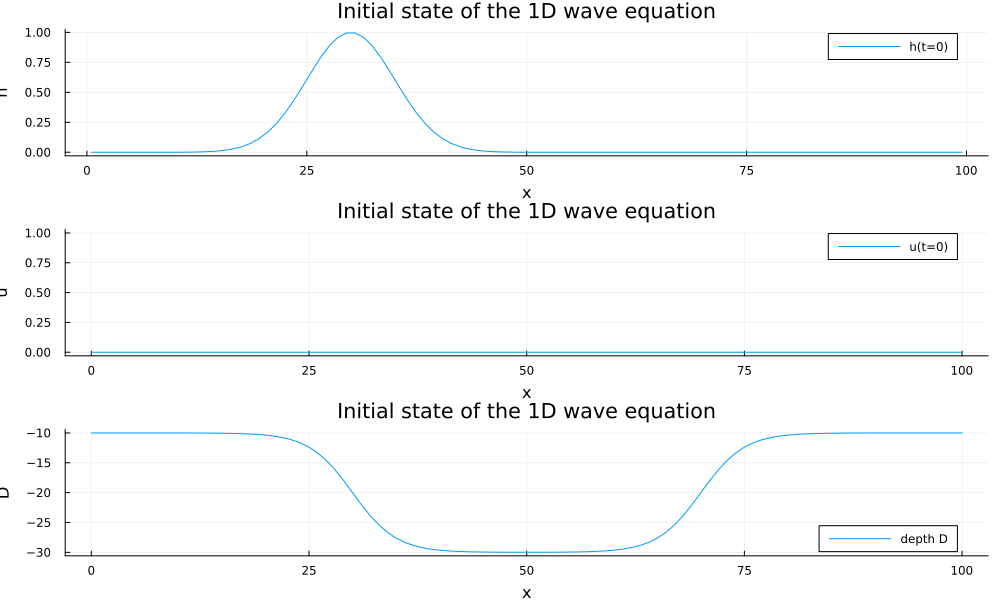

In [14]:
# plot the initial state
p1=plot(1e-3*x_h, x0.h, label="h(t=0)", xlabel="x", ylabel="h")
p2=plot(1e-3*x_u, x0.u, label="u(t=0)", xlabel="x", ylabel="u")
p3=plot(1e-3*x_u, -D, label="depth D", xlabel="x", ylabel="D")
plot(p1, p2, p3, layout=(3,1), size=(1000,600),title="Initial state of the 1D wave equation")

size(dx_dt.h) = (100,)
size(dx_dt.u) = (101,)


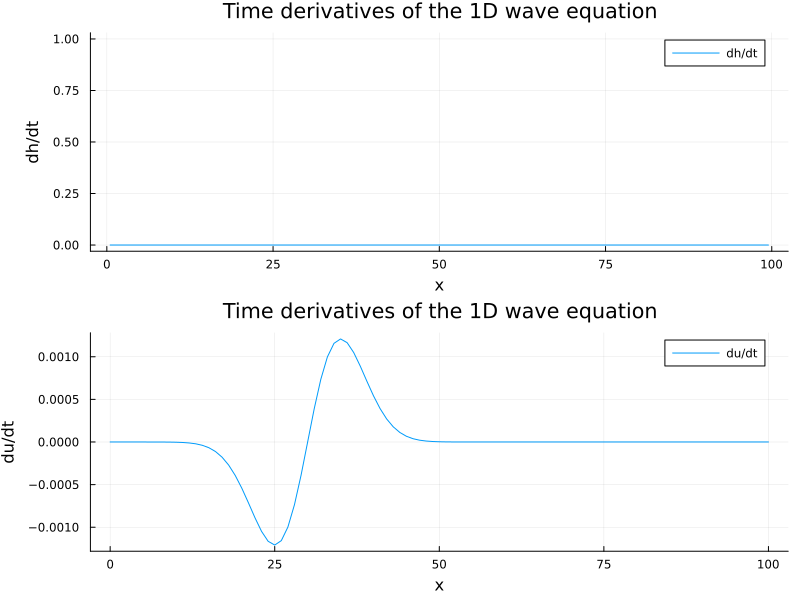

In [15]:
# check model components 
dx_dt=similar(x0)
f(dx_dt,x0,f,t_start)
@show size(dx_dt.h)
@show size(dx_dt.u)
p1=plot(1e-3*x_h, dx_dt.h, label="dh/dt", xlabel="x", ylabel="dh/dt")
p2=plot(1e-3*x_u, dx_dt.u, label="du/dt", xlabel="x", ylabel="du/dt")
plot(p1, p2, layout=(2,1), size=(800,600), title="Time derivatives of the 1D wave equation")

In [16]:
prob = ODEProblem(f, x0, (t_start, t_end))
@time sol = solve(prob, Tsit5(),saveat=10.0) # with timing, but ouput only at t=10.0
sol = solve(prob, Tsit5()) # store output, no timing

nothing

  1.593874 seconds (7.76 M allocations: 428.077 MiB, 7.19% gc time, 99.87% compilation time)


┌ Info: Saved animation to /home/verlaan/dellete/src/julia_ml_tests.jl.git/model_1d/wave1d_periodic.gif
└ @ Plots /home/verlaan/.julia/packages/Plots/uiCPf/src/animation.jl:156


  9.421784 seconds (6.33 M allocations: 342.421 MiB, 0.54% gc time, 4.39% compilation time: 9% of which was recompilation)


Plots.AnimatedGif("/home/verlaan/dellete/src/julia_ml_tests.jl.git/model_1d/wave1d_periodic.gif")
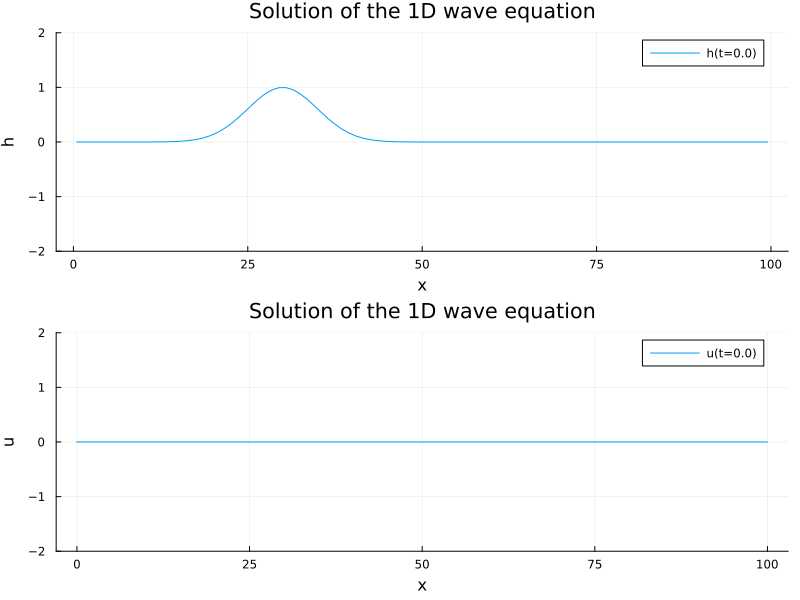

In [ ]:
# create a movie of the solution
@time begin
    # create a movie of the solution
    anim = @animate for i in 1:length(sol.t)
        p1 = plot(1e-3*x_h, sol[i].h, label="h(t=$(round(sol.t[i]/3600,digits=1)))", xlabel="x", ylabel="h", ylim=(-2, 2))
        p2 = plot(1e-3*x_u, sol[i].u, label="u(t=$(round(sol.t[i]/3600,digits=1)))", xlabel="x", ylabel="u", ylim=(-2, 2))
        plot(p1, p2, layout=(2,1), size=(800,600), title="Solution of the 1D wave equation")
    end
    gif(anim, "wave1d_surge.gif", fps=30)
end


In [ ]:
# save the solution to a JLD2 file
cfl_out=1.0 # CFL number for output
dt_out=cfl_out*f.dx/(sqrt(f.D*f.g)) # time step for output, based on CFL condition
times=collect(0.0:dt_out:t_end) # output times
solution=[]
for t in times
    push!(solution, sol(t))
end
# save the solution to a JLD2 file
save("wave1d_surge.jld2", 
    "solution", solution,
    "times", times,
    "params", (g=f.g, D=f.D, L=f.L, dx=f.dx, nx=f.nx),
    "grid", x,
    "cfl_out", cfl_out,
    "dt_out", dt_out,
    "description", "Solution of the 1D wave equation with periodic boundary conditions, using a Gaussian bump as initial condition.")


MethodError: MethodError: no method matching sqrt(::Vector{Float64})
The function `sqrt` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  sqrt(!Matched::Float16)
   @ Base math.jl:1511
  sqrt(!Matched::ComplexF16)
   @ Base math.jl:1512
  sqrt(!Matched::Missing)
   @ Base math.jl:1533
  ...


In [ ]:
# load the solution from the JLD2 file for testing
ff=load("wave1d_surge.jld2")

@show ff["solution"][1].h[1:20:end] # show some values of the initial height field